In [1]:

import hydra
import wandb
from ott.neural import datasets
import sys
from omegaconf import DictConfig
import jax.numpy as jnp
from jax import random
from typing import Optional, Literal
import jax
import pathlib
import optax
import yaml
from datetime import datetime
from flax import linen as nn
import functools
from tqdm import tqdm
from flax.training import train_state

from ott.neural.networks.layers import time_encoder
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks import velocity_field
from ott.solvers import utils as solver_utils
import jax.tree_util as jtu
from ott.neural.networks.layers import time_encoder

import hydra
from omegaconf import DictConfig, OmegaConf

from torch.utils.data import DataLoader
import numpy as np

import scanpy as sc
from ot_pert.metrics import compute_metrics, compute_mean_metrics
from ot_pert.nets.nets import VelocityFieldWithAttention
from ot_pert.utils import ConditionalLoader


In [2]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray], tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray], tgt_quad: Optional[jnp.ndarray], *,
    typ: Literal["lin", "quad", "fused"]
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(x=src_lin, y=tgt_lin, scale_cost="mean")
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(
            xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin
        )
    raise NotImplementedError(f"Unknown type: {typ}.")

In [164]:
adata_train_path= "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train.h5ad"
adata_test_path= "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test.h5ad"
adata_ood_path= "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood.h5ad"
obsm_key_data= "X_pca"
obsm_key_cond_1= "ecfp_drug_1"
obsm_key_cond_2= "ecfp_drug_2"
batch_size=13

In [166]:
dls = []
train_data_source = {}
train_data_target = {}
train_data_conditions = {}

source = adata_train[adata_train.obs["condition"]=="control"].obsm[obsm_key_data]
for cond in adata_train.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_data]
    condition_1 = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_cond_1]
    condition_2 = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_cond_2]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(np.concatenate((condition_1[0,:][None,:],condition_2[0,:][None,:]), axis=0), axis=0)
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    dls.append(DataLoader(datasets.OTDataset(datasets.OTData(
        lin=source,
        condition=conds,
    ), datasets.OTData(lin=target)), batch_size=batch_size, shuffle=True))
    train_data_source[cond] = source
    train_data_target[cond] = target
    train_data_conditions[cond] = conds

train_loader = ConditionalLoader(dls, seed=0)

test_data_source = {}
test_data_target = {}
test_data_conditions = {}
adata_test = sc.read(adata_test_path)
source = adata_test[adata_test.obs["condition"]=="control"].obsm[obsm_key_data]
for cond in adata_test.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_data]
    condition_1 = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_cond_1]
    condition_2 = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_cond_2]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(np.concatenate((condition_1[0,:][None,:],condition_2[0,:][None,:]), axis=0), axis=0)
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_conditions[cond] = conds

ood_data_source = {}
ood_data_target = {}
ood_data_conditions = {}
adata_ood = sc.read(adata_ood_path)
source = adata_ood[adata_ood.obs["condition"]=="control"].obsm[obsm_key_data]
for cond in adata_ood.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_data]
    condition_1 = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_cond_1]
    condition_2 = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_cond_2]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(np.concatenate((condition_1[0,:][None,:],condition_2[0,:][None,:]), axis=0), axis=0)
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_conditions[cond] = conds

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
class ConditionalLoader2:
  """Dataset for OT problems with conditions.

  This data loader wraps several data loaders and samples from them.

  Args:
    datasets: Datasets to sample from.
    seed: Random seed.
  """

  def __init__(
      self,
      dataloaders: Iterable[DataLoader],
      seed: int = 0,
  ):
    self.dataloaders = tuple(dataloaders)
    self._rng = jax.random.PRNGKey(seed)
    
  def __next__(self):
    rng, self._rng = jax.random.split(self._rng, 2)
    idx = int(jax.random.choice(rng, len(self.dataloaders)))
    dl = self.dataloaders[idx]
    return next(iter(dl))


  def __iter__(self) -> "ConditionalLoader":
    return self

  def __len__(self) -> int:
    return len(self.dataloaders)

In [11]:
#train_loader = ConditionalLoader(dls, seed=0)

In [167]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

vf = VelocityFieldWithAttention(
        num_heads=2,
        qkv_feature_dim=32,
        max_seq_length=2,
        hidden_dims=[512, 512],
        time_dims=[512, 512],
        output_dims=[512, 512]+[target_dim],
        condition_dims=[512, 512],
        time_encoder = functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1025),
        )
    
model = otfm.OTFlowMatching(vf,
    flow=dynamics.ConstantNoiseFlow(0),
    match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 5)
)

training_logs = {"loss": []}

rng = jax.random.PRNGKey(0)
for it in tqdm(range(5000)):
    rng, rng_resample, rng_step_fn = jax.random.split(rng, 3)
    batch = next(train_loader)
    batch = jtu.tree_map(jnp.asarray, batch)

    src, tgt = batch["src_lin"], batch["tgt_lin"]
    src_cond = batch.get("src_condition")

    if model.match_fn is not None:
        tmat = model.match_fn(src, tgt)
        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        src, tgt = src[src_ixs], tgt[tgt_ixs]
        src_cond = None if src_cond is None else src_cond[src_ixs]

    model.vf_state, loss = model.step_fn(
        rng_step_fn,
        model.vf_state,
        src,
        tgt,
        src_cond,
    )

100%|██████████| 5000/5000 [00:44<00:00, 113.03it/s]


In [168]:
src = test_data_source['Alvespimycin+Pirarubicin'][0][None,:]
cond = test_data_conditions['Alvespimycin+Pirarubicin'][0][None,:]

In [170]:
cond_1= cond[:,[1,0],:]

In [173]:
(cond_1 == cond).all()

False

In [179]:
cond.shape, cond_1.shape

((1, 2, 1024), (1, 2, 1024))

In [180]:
(cond[:,0,:] == cond_1[:,1,:]).all()

True

In [181]:
(cond[:,1,:] == cond_1[:,0,:]).all()

True

In [182]:
(cond[:,0,:] == cond_1[:,0,:]).all()

False

In [183]:
(cond[:,1,:] == cond_1[:,1,:]).all()

False

In [174]:
out_1 = model.transport(src, cond)

In [175]:
out_2 = model.transport(src, cond_1)

In [177]:
(out_1 == out_2).all()

Array(False, dtype=bool)

In [317]:
from typing import Callable, Optional, Sequence, List

import jax
import jax.numpy as jnp

import optax
from flax import linen as nn
from flax.training import train_state

from ott.neural.networks.layers import time_encoder
import functools


def get_masks(dataset: List[jnp.ndarray]):
    attention_mask = []
    for data in dataset:
        if data.ndim<2:
            data = data[None, :]
        if data.ndim<3:
            data = data[None, :]
        mask = jnp.all(data == 0.0, axis=-1)
        mask = 1-mask
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.expand_dims(jnp.array(attention_mask), 1)



class VelocityFieldWithAttention2(nn.Module):
    num_heads: int
    qkv_feature_dim: int
    max_seq_length: int
    hidden_dims: Sequence[int]
    output_dims: Sequence[int]
    condition_dims: Optional[Sequence[int]] = None
    time_dims: Optional[Sequence[int]] = None
    time_encoder: Callable[[jnp.ndarray],
                         jnp.ndarray] = time_encoder.cyclical_time_encoder
    act_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.silu
    pad_max_dim: int = -1

    def __post_init__(self):
        self.get_masks = jax.jit(get_masks)
        super().__post_init__()


    @nn.compact
    def __call__(
      self,
      t: jnp.ndarray,
      x: jnp.ndarray,
      condition: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        """Forward pass through the neural vector field.
        
        Args:
          t: Time of shape ``[batch, 1]``.
          x: Data of shape ``[batch, ...]``.
          condition: Conditioning vector of shape ``[batch, ...]``.
        
        Returns:
          Output of the neural vector field of shape ``[batch, output_dim]``.
        """
        squeeze_output = False
        if x.ndim < 2:
            x = x[None,:]
            t = jnp.full(shape=(1, 1), fill_value=t)
            condition = condition[None,:]
            squeeze_output = True
            
        time_dims = self.hidden_dims if self.time_dims is None else self.time_dims
        t = self.time_encoder(t)
        for time_dim in time_dims:
          t = self.act_fn(nn.Dense(time_dim)(t))
        
        for hidden_dim in self.hidden_dims:
          x = self.act_fn(nn.Dense(hidden_dim)(x))
    
        assert condition is not None, "No condition sequence was passed."

        token_shape = (len(condition),1) if condition.ndim > 2 else (1,)
        class_token = nn.Embed(num_embeddings=1, features=condition.shape[-1])(jnp.int32(jnp.zeros(token_shape)))

        condition = jnp.concatenate((class_token, condition), axis=1)
        mask = self.get_masks(condition) 
        
        attention = nn.MultiHeadDotProductAttention(num_heads=self.num_heads, qkv_features=self.qkv_feature_dim)
        emb = attention(condition, mask=mask)
        #print(emb.shape)
        #jax.debug.print("emb id {x}", x=emb[:,0,:])
        emb = emb[:,0,:] # only continue with token 0
        
        for cond_dim in self.condition_dims:
            condition = self.act_fn(nn.Dense(cond_dim)(emb))
    
        #jax.debug.print("x {x}", x=x)
        feats = jnp.concatenate([t, x, condition], axis=1)
        
        for output_dim in self.output_dims[:-1]:
          feats = self.act_fn(nn.Dense(output_dim)(feats))
        
        # no activation function for the final layer
        out =  nn.Dense(self.output_dims[-1])(feats)
        jax.debug.print("out is {x}", x=out)
        
        return jnp.squeeze(out) if squeeze_output else out

    def create_train_state(
          self,
          rng: jax.Array,
          optimizer: optax.OptState,
          input_dim: int,
          condition_dim: Optional[int] = None,
      ) -> train_state.TrainState:
        """Create the training state.
    
        Args:
          rng: Random number generator.
          optimizer: Optimizer.
          input_dim: Dimensionality of the velocity field.
          condition_dim: Dimensionality of the condition of the velocity field.
    
        Returns:
          The training state.
        """
        t, x = jnp.ones((1, 1)), jnp.ones((1, input_dim))
        if self.condition_dims is None:
          cond = None
        else:
          assert condition_dim > 0, "Condition dimension must be positive."
          cond = jnp.ones((1, 1, condition_dim))
    
        params = self.init(rng, t, x, cond)["params"]
        return train_state.TrainState.create(
            apply_fn=self.apply, params=params, tx=optimizer
        )

In [318]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

vf = VelocityFieldWithAttention2(
        num_heads=2,
        qkv_feature_dim=32,
        max_seq_length=2,
        hidden_dims=[512, 512],
        time_dims=[512, 512],
        output_dims=[512, 512]+[target_dim],
        condition_dims=[512, 512],
        time_encoder = functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1025),
        )
    
model = otfm.OTFlowMatching(vf,
    flow=dynamics.ConstantNoiseFlow(0),
    match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 5)
)

training_logs = {"loss": []}

rng = jax.random.PRNGKey(0)
for it in tqdm(range(20)):
    rng, rng_resample, rng_step_fn = jax.random.split(rng, 3)
    batch = next(train_loader)
    batch = jtu.tree_map(jnp.asarray, batch)

    src, tgt = batch["src_lin"], batch["tgt_lin"]
    src_cond = batch.get("src_condition")

    if model.match_fn is not None:
        tmat = model.match_fn(src, tgt)
        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        src, tgt = src[src_ixs], tgt[tgt_ixs]
        src_cond = None if src_cond is None else src_cond[src_ixs]

    model.vf_state, loss = model.step_fn(
        rng_step_fn,
        model.vf_state,
        src,
        tgt,
        src_cond,
    )

out is [[ 0.01938387 -0.01381458 -0.04531386  0.00122085  0.08061172  0.02274034
   0.03487904 -0.09694871  0.05760881 -0.11893062 -0.03717537 -0.08276401
   0.14499742  0.00608561 -0.04188076  0.06114614  0.06004605 -0.05159447
  -0.08338302  0.10087156  0.07756275 -0.02305393  0.02523501  0.07244726
  -0.01820154 -0.11658673  0.02726241  0.1242374  -0.09809114  0.02752599]]


 45%|████▌     | 9/20 [00:02<00:02,  5.02it/s]

out is [[ 9.77237374e-02 -2.54843244e-03 -5.69099039e-02 -1.28244877e-01
  -8.45484510e-02  8.53342861e-02 -3.79731879e-02 -1.34324268e-01
  -9.75455344e-02  6.73209429e-02 -7.44500980e-02 -1.54488729e-02
   1.60409622e-02 -5.90839759e-02  1.77221838e-02  3.85993049e-02
   1.29896030e-03  5.10765128e-02 -7.52004907e-02 -6.38557784e-03
  -2.37219296e-02 -2.68610027e-02 -1.42856129e-02  8.22566152e-02
  -3.13041434e-02  5.46243042e-02 -1.97623037e-02  1.85506269e-01
  -1.36359446e-02 -1.24062244e-02]
 [ 6.57140389e-02 -2.59814374e-02  8.44534114e-03 -6.21962473e-02
  -8.33109543e-02  2.48366203e-02 -5.06012887e-02  2.12686602e-03
  -1.74872857e-02  2.63701752e-02  3.80023494e-02  2.93839034e-02
   2.38447133e-02 -7.78112188e-02 -4.00931165e-02  1.78973805e-02
   2.96464823e-02  1.52638368e-02 -2.43062805e-02  1.46944076e-04
   4.75574732e-02 -4.43761097e-03 -6.05004802e-02 -4.16412205e-03
   2.85349116e-02  2.97155231e-02  7.84322694e-02  8.16415623e-02
  -1.24478452e-02 -5.72547391e-02]

100%|██████████| 20/20 [00:02<00:00,  7.74it/s]

out is [[ 7.66418204e-02 -1.48064733e-01 -6.55686781e-02 -2.77980231e-02
   8.79829843e-03 -5.00460118e-02  4.72873822e-02 -7.45052658e-03
  -7.23448768e-02 -4.50752750e-02  2.55460199e-02  4.65487055e-02
   4.56461012e-02 -5.03174923e-02  5.77141307e-02 -1.95727572e-02
   8.44214037e-02 -1.76649690e-02 -1.23585686e-02  7.53828511e-02
  -4.48835269e-02 -1.33028056e-03 -9.58304256e-02 -1.51030049e-01
  -5.05150892e-02  1.82515401e-02 -2.59310082e-02  1.49396865e-03
   9.86900553e-02 -6.18291013e-02]
 [ 1.07468307e-01 -1.62510380e-01 -2.08792880e-01 -1.08615085e-01
  -6.22384511e-02 -1.75558254e-02 -4.66260966e-03 -7.92775303e-02
   8.21056962e-03 -8.18364918e-02  2.05317922e-02  3.97263141e-03
  -5.96326143e-02  1.23386541e-02 -9.17464902e-04  1.12349860e-01
   1.39180988e-01 -1.60795301e-02  4.80147824e-02  1.03370724e-02
  -1.12859644e-01  1.32365245e-02 -6.25120252e-02  2.75847353e-02
  -7.46416524e-02 -1.98447630e-02 -1.34047329e-01  5.39974868e-02
   2.20251624e-02 -9.76797044e-02]

In [345]:
cond.shape

(1, 2, 1024)

In [319]:
src = test_data_source['Alvespimycin+Pirarubicin'][0][None,:]
cond = test_data_conditions['Alvespimycin+Pirarubicin'][0][None,:]

In [320]:
cond_1= cond[:,[1,0],:]

In [321]:
(cond_1 == cond).all()

False

In [322]:
out_1 = model.transport(src, cond)

out is [[ 0.05633949 -0.1638875  -0.14564115 -0.0198136   0.0608415  -0.07757016
  -0.08632525 -0.02097926  0.10483112 -0.04946343 -0.0280772   0.02225993
  -0.01393615  0.06067562 -0.01141853  0.09769102  0.04291495 -0.06263604
   0.00777018 -0.02770214  0.04742165 -0.0121023  -0.00931156  0.00572913
  -0.06650875 -0.10383555 -0.0625154   0.03258841  0.03845524 -0.08229822]]
out is [[ 0.06764651 -0.0944784  -0.0945041  -0.00822171 -0.03231791 -0.10970384
  -0.08652287 -0.05471902  0.06165656 -0.05616318 -0.03844532  0.03521505
   0.033792    0.00440596 -0.00647629  0.09657571  0.01857367 -0.0323309
   0.02380049 -0.09678774  0.00075305 -0.02348362  0.00461368 -0.07868822
  -0.01728538 -0.06122244 -0.06816404 -0.00892031  0.09045082  0.01063303]]
out is [[ 0.03183686 -0.23343773 -0.10998102  0.02916179 -0.05610567 -0.06055034
  -0.19209577 -0.00416646  0.02010914  0.00606018 -0.0300494   0.05582833
  -0.04971089  0.032377    0.03583783  0.06546958  0.0061775  -0.08223165
   0.0035626  

In [323]:
out_2 = model.transport(src, cond_1)

out is [[ 0.05633947 -0.1638875  -0.14564116 -0.01981358  0.06084146 -0.07757015
  -0.08632527 -0.02097926  0.10483113 -0.04946342 -0.02807718  0.02225994
  -0.01393613  0.06067559 -0.01141853  0.097691    0.04291496 -0.06263603
   0.00777019 -0.02770213  0.04742164 -0.01210228 -0.00931156  0.00572913
  -0.06650875 -0.10383554 -0.06251538  0.0325884   0.03845524 -0.0822982 ]]
out is [[ 0.0676465  -0.09447841 -0.0945041  -0.00822169 -0.03231793 -0.10970383
  -0.08652287 -0.054719    0.06165659 -0.05616319 -0.03844531  0.03521505
   0.03379202  0.00440596 -0.00647628  0.09657567  0.01857368 -0.03233089
   0.02380052 -0.09678774  0.00075307 -0.02348361  0.00461369 -0.07868817
  -0.01728538 -0.06122243 -0.06816405 -0.00892033  0.09045083  0.01063305]]
out is [[ 0.03183684 -0.2334377  -0.10998101  0.0291618  -0.05610569 -0.06055032
  -0.19209579 -0.00416648  0.02010912  0.0060602  -0.0300494   0.05582829
  -0.04971089  0.03237703  0.03583783  0.06546959  0.00617751 -0.08223165
   0.00356259

In [316]:
(out_1 == out_2).all()

Array(False, dtype=bool)

In [269]:
np.max(out_1 - out_2)

Array(0.00471702, dtype=float32)

In [346]:
out_1.shape

(1, 30)

In [213]:
src.shape

(1, 30)

In [208]:
cond.shape

(1, 2, 1024)

In [209]:
out_1 = model.transport(src, cond)

In [210]:
out_2 = model.transport(src, cond)

In [212]:
cond_1

array([[[ 0.        , -0.35424594, -0.24253562, ...,  0.        ,
          0.        , -0.24253562],
        [ 0.        , -0.35424594, -0.24253562, ...,  0.        ,
          0.        , -0.24253562]]])

In [190]:
src.shape

(13, 30)

In [142]:
bdata = adata_test[adata_test.obs["perturbation"]=='Alvespimycin+Pirarubicin']

In [151]:
list(bdata.obs["smiles_drug_1"].unique()) == list(bdata.obs["smiles_drug_2"].unique())

False

In [155]:
(bdata.obsm["ecfp_drug_1"] == bdata.obsm["ecfp_drug_1"]).all()

True

In [124]:
test_data_source['Alvespimycin+Pirarubicin'][0][None,:].shape

(1, 30)

In [ ]:
pred_1 = model.transport()

In [122]:
test_data_source['Alvespimycin+Pirarubicin'][0].shape, test_data_conditions['Alvespimycin+Pirarubicin'][0].shape

((30,), (2, 1024))

In [72]:
predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source, test_data_conditions)

In [91]:
test_metrics = jtu.tree_map(my_compute_metrics, predicted_target_test, test_data_target)

In [92]:
mean_test_metrics = compute_mean_metrics(test_metrics, prefix="test_")

In [93]:
mean_test_metrics

{'test_r_squared': [], 'r_squared': -0.1613270389181651}

In [161]:
test_data_source = {}
test_data_target = {}
test_data_conditions = {}

cond = 'Alvespimycin+Pirarubicin'
target = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_data]
condition_1 = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_cond_1]
condition_2 = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_cond_2]
assert np.all(np.all(condition_1 == condition_1[0], axis=1))
assert np.all(np.all(condition_2 == condition_2[0], axis=1))
expanded_arr = np.expand_dims(np.concatenate((condition_1[0,:][None,:],condition_2[0,:][None,:]), axis=0), axis=0)
conds = np.tile(expanded_arr, (len(source), 1, 1))
test_data_source[cond] = source
test_data_target[cond] = target
test_data_conditions[cond] = conds

In [162]:
test_data_source

{'Alvespimycin+Pirarubicin': ArrayView([[-2.9232855e+00,  1.3026075e+00, -4.2610037e-01, ...,
             -7.7588570e-01, -4.0540862e-01,  1.5549358e+00],
            [-2.7569227e+00, -2.4520164e+00,  1.5370195e+00, ...,
              1.3818368e-01,  4.4321913e-02, -9.0514755e-01],
            [-1.7238822e+00, -1.5226791e+00, -1.5261246e-01, ...,
             -9.8001397e-01,  7.6922262e-01,  1.1310315e+00],
            ...,
            [-2.7527654e+00,  4.4897256e+00, -9.5735639e-01, ...,
              3.8120649e-03,  4.9444807e-01, -8.3889055e-01],
            [-2.0278578e+00,  1.0547891e+00, -1.0361682e+00, ...,
              1.3078570e-01,  8.0470544e-01,  9.7677447e-02],
            [-3.9932654e+00,  1.0484935e+00, -5.9191234e-02, ...,
             -1.0344353e+00, -8.5763979e-01, -1.3952967e+00]],
           dtype=float32)}

In [163]:
(condition_1 == condition_2).all()

False

In [67]:
mean_test_metrics

{'test_r_squared': [], 'r_squared': -0.07531033044386308}

In [76]:
loss_dict = {"train_loss": loss}

In [86]:
loss_dict.update(mean_test_metrics)

In [87]:
loss_dict

{'train_loss': Array(0.20256655, dtype=float32),
 'test_r_squared': [],
 'r_squared': -0.1613270389181651}

In [88]:
loss_dict.update(mean_ood_metrics)

In [89]:
loss_dict

{'train_loss': Array(0.20256655, dtype=float32),
 'test_r_squared': [],
 'r_squared': -2.62764481371016}

In [77]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)

In [78]:
ood_metrics = jtu.tree_map(my_compute_metrics, predicted_target_ood, ood_data_target)

In [79]:
mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="test_")

In [80]:
mean_ood_metrics

{'test_r_squared': [], 'r_squared': 0.21197287566022}

In [96]:
m = jtu.tree_map(compute_metrics, ood_data_source, ood_data_target)
mean_ood_metrics = compute_mean_metrics(m, prefix="test_")

In [97]:
mean_ood_metrics

{'test_r_squared': [],
 'test_sinkhorn_div_01': [],
 'test_e_distance': [],
 'test_mmd': [],
 'r_squared': -2.62764481371016,
 'sinkhorn_div_01': 54.35254440307617,
 'e_distance': 5.064446949747692,
 'mmd': 37.39942092895508}

In [68]:
test_metrics = jtu.tree_map(my_compute_metrics, test_data_source, test_data_target)

In [70]:
compute_mean_metrics(test_metrics, prefix="test_")

{'test_r_squared': [], 'r_squared': -1.736959665179751}

In [60]:
def my_compute_mean_metrics(metrics: Dict[str, Dict[str, float]], prefix: str = ""):
    metric_names = list(list(metrics.values())[0].keys())
    metric_dict = {prefix+met_name: [] for met_name in metric_names}
    for met in metric_names:
        stat = 0.0
        for vals in metrics.values():
            stat += vals[met]
        metric_dict[prefix+met] = stat/len(metrics)
    return metric_dict

In [61]:
my_compute_mean_metrics(test_metrics, prefix="test_")

{'test_r_squared': -3.5588256209986255}

In [39]:
from ot_pert.metrics import compute_r_squared

In [48]:
from typing import Dict
def my_compute_metrics(x: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    metrics = {}
    metrics["r_squared"] = compute_r_squared(x, y)
    #metrics["sinkhorn_div_01"] = compute_sinkhorn_div(x, y, epsilon=0.1)
    #metrics["sinkhorn_div_1"] = compute_sinkhorn_div(x, y, epsilon=1.0)
    #metrics["sinkhorn_div_10"] = compute_sinkhorn_div(x, y, epsilon=10.0)
    #metrics["e_distance"] = compute_e_distance(x, y)
    #metrics["mmd"] = compute_sinkhorn_div(x, y, epsilon=100_000)
    return metrics

In [45]:
def compute_metrics_2(x,y):
    return compute_r_squared(x,y)

In [49]:
jtu.tree_map(my_compute_metrics ,predicted_target_test, test_data_target)

{'Alvespimycin+Pirarubicin': {'r_squared': -0.7466006158068266},
 'Cediranib+PCI-34051': {'r_squared': 0.8640461270769257},
 'Dacinostat+Dasatinib': {'r_squared': -9.682569086856425},
 'Dacinostat+PCI-34051': {'r_squared': -9.987457531575235},
 'Givinostat+Carmofur': {'r_squared': -1.0107396383636411},
 'Givinostat+Cediranib': {'r_squared': -0.9845886639260741},
 'Givinostat+Crizotinib': {'r_squared': -1.1409188410728945},
 'Givinostat+Curcumin': {'r_squared': -1.0071303950176702},
 'Givinostat+Dasatinib': {'r_squared': -1.4685804937050633},
 'Givinostat+SRT2104': {'r_squared': -1.1926887220068818},
 'Givinostat+Sorafenib': {'r_squared': -2.0905154065024982},
 'Givinostat+Tanespimycin': {'r_squared': -1.1907641168137788},
 'Panobinostat+Alvespimycin': {'r_squared': -10.067461330557448},
 'Panobinostat+Crizotinib': {'r_squared': -9.669594057637498},
 'Panobinostat+Dasatinib': {'r_squared': -5.763317813628087},
 'Panobinostat+SRT1720': {'r_squared': -3.909559664756981},
 'Panobinostat+SR

In [40]:
jtu.tree_map(compute_r_squared ,predicted_target_test, test_data_target)

{'Alvespimycin+Pirarubicin': -0.7466006158068266,
 'Cediranib+PCI-34051': 0.8640461270769257,
 'Dacinostat+Dasatinib': -9.682569086856425,
 'Dacinostat+PCI-34051': -9.987457531575235,
 'Givinostat+Carmofur': -1.0107396383636411,
 'Givinostat+Cediranib': -0.9845886639260741,
 'Givinostat+Crizotinib': -1.1409188410728945,
 'Givinostat+Curcumin': -1.0071303950176702,
 'Givinostat+Dasatinib': -1.4685804937050633,
 'Givinostat+SRT2104': -1.1926887220068818,
 'Givinostat+Sorafenib': -2.0905154065024982,
 'Givinostat+Tanespimycin': -1.1907641168137788,
 'Panobinostat+Alvespimycin': -10.067461330557448,
 'Panobinostat+Crizotinib': -9.669594057637498,
 'Panobinostat+Dasatinib': -5.763317813628087,
 'Panobinostat+SRT1720': -3.909559664756981,
 'Panobinostat+SRT2104': -4.9626385479785,
 'Panobinostat+SRT3025': -6.8340181074459325,
 'Panobinostat+Sorafenib': -6.707075410466809,
 'SRT3025+Cediranib': -0.6193600119825751,
 'control+Alvespimycin': -1.6110256294625311,
 'control+Dacinostat': -3.876929

In [38]:
jtu.tree_map(lambda x: x.shape ,test_data_target)

{'Alvespimycin+Pirarubicin': (100, 30),
 'Cediranib+PCI-34051': (100, 30),
 'Dacinostat+Dasatinib': (100, 30),
 'Dacinostat+PCI-34051': (100, 30),
 'Givinostat+Carmofur': (100, 30),
 'Givinostat+Cediranib': (100, 30),
 'Givinostat+Crizotinib': (100, 30),
 'Givinostat+Curcumin': (100, 30),
 'Givinostat+Dasatinib': (100, 30),
 'Givinostat+SRT2104': (100, 30),
 'Givinostat+Sorafenib': (100, 30),
 'Givinostat+Tanespimycin': (100, 30),
 'Panobinostat+Alvespimycin': (100, 30),
 'Panobinostat+Crizotinib': (100, 30),
 'Panobinostat+Dasatinib': (100, 30),
 'Panobinostat+SRT1720': (100, 30),
 'Panobinostat+SRT2104': (100, 30),
 'Panobinostat+SRT3025': (100, 30),
 'Panobinostat+Sorafenib': (100, 30),
 'SRT3025+Cediranib': (100, 30),
 'control+Alvespimycin': (100, 30),
 'control+Dacinostat': (100, 30),
 'control+Dasatinib': (100, 30),
 'control+Givinostat': (100, 30),
 'control+Panobinostat': (100, 30),
 'control+SRT2104': (100, 30)}

In [243]:
def get_masks(dataset: List[jnp.ndarray], pad_max_dim: Optional[int] = None, pad_token=0):
    attention_mask = []
    for data in dataset:
        if data.ndim<2:
            data = data[None, :]
        if data.ndim<3:
            data = data[None, :]
        print(data.shape)
        mask = jnp.all(cond_1 == 0.0, axis=-1)
        print(mask.shape)
        mask = 1-mask
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.expand_dims(jnp.array(attention_mask), 1)

In [347]:
def get_masks(dataset: List[jnp.ndarray]):
    attention_mask = []
    for data in dataset:
        if data.ndim<2:
            data = data[None, :]
        if data.ndim<3:
            data = data[None, :]
        mask = jnp.all(data == 0.0, axis=-1)
        mask = 1-mask
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.expand_dims(jnp.equal(jnp.array(attention_mask),1.0), 1)

In [330]:
bool(1- False)

True

In [361]:
cond_1 = jnp.ones(cond_1.shape)

In [362]:
c = np.array(cond_1)

In [363]:
c[:,1,:] = 0

In [365]:
c

array([[[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [364]:
get_masks(c)

Array([[[[ True, False],
         [False, False]]]], dtype=bool, weak_type=True)

In [359]:
get_masks(cond_1)

Array([[[[ True,  True],
         [ True,  True]]]], dtype=bool, weak_type=True)

In [238]:
jnp.all(cond_1 == 0.0, axis=-1)

Array([[False, False]], dtype=bool)

In [237]:
cond_1[..., 0].shape

(1, 2)

In [248]:
from typing import Callable, Optional, Sequence, List

import jax
import jax.numpy as jnp

import optax
from flax import linen as nn
from flax.training import train_state

from ott.neural.networks.layers import time_encoder
import functools


def get_masks(dataset: List[jnp.ndarray]):
    attention_mask = []
    for data in dataset:
        if data.ndim<2:
            data = data[None, :]
        if data.ndim<3:
            data = data[None, :]
        print(data.shape)
        mask = jnp.all(cond_1 == 0.0, axis=-1)
        print(mask.shape)
        mask = 1-mask
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.expand_dims(jnp.array(attention_mask), 1)



class VelocityFieldWithAttention2(nn.Module):
    num_heads: int
    qkv_feature_dim: int
    max_seq_length: int
    hidden_dims: Sequence[int]
    output_dims: Sequence[int]
    condition_dims: Optional[Sequence[int]] = None
    time_dims: Optional[Sequence[int]] = None
    time_encoder: Callable[[jnp.ndarray],
                         jnp.ndarray] = time_encoder.cyclical_time_encoder
    act_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.silu
    pad_max_dim: int = -1

    def __post_init__(self):
        self.get_masks = jax.jit(get_masks)
        super().__post_init__()


    @nn.compact
    def __call__(
      self,
      t: jnp.ndarray,
      x: jnp.ndarray,
      condition: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        """Forward pass through the neural vector field.
        
        Args:
          t: Time of shape ``[batch, 1]``.
          x: Data of shape ``[batch, ...]``.
          condition: Conditioning vector of shape ``[batch, ...]``.
        
        Returns:
          Output of the neural vector field of shape ``[batch, output_dim]``.
        """
        squeeze_output = False
        if x.ndim < 2:
            x = x[None,:]
            t = jnp.full(shape=(1, 1), fill_value=t)
            condition = condition[None,:]
            squeeze_output = True
            
        time_dims = self.hidden_dims if self.time_dims is None else self.time_dims
        t = self.time_encoder(t)
        for time_dim in time_dims:
          t = self.act_fn(nn.Dense(time_dim)(t))
        
        for hidden_dim in self.hidden_dims:
          x = self.act_fn(nn.Dense(hidden_dim)(x))
    
        assert condition is not None, "No condition sequence was passed."

        token_shape = (len(condition),1) if condition.ndim > 2 else (1,)
        class_token = nn.Embed(num_embeddings=1, features=condition.shape[-1])(jnp.int32(jnp.zeros(token_shape)))
        
        condition = jnp.concatenate((class_token, condition), axis=-2)
        print("condition shape is ", condition.shape)
        mask = self.get_masks(condition) 
        print("mask.shape is ", mask.shape)
            
        attention = nn.MultiHeadDotProductAttention(num_heads=self.num_heads, qkv_features=self.qkv_feature_dim)
        emb = attention(condition, mask=mask)
        emb = emb[:,0,:] # only continue with token 0
        
        for cond_dim in self.condition_dims:
            condition = self.act_fn(nn.Dense(cond_dim)(emb))
    
        
        feats = jnp.concatenate([t, x, condition], axis=1)
        
        for output_dim in self.output_dims[:-1]:
          feats = self.act_fn(nn.Dense(output_dim)(feats))
        
        # no activation function for the final layer
        out =  nn.Dense(self.output_dims[-1])(feats)
        return jnp.squeeze(out) if squeeze_output else out

    def create_train_state(
          self,
          rng: jax.Array,
          optimizer: optax.OptState,
          input_dim: int,
          condition_dim: Optional[int] = None,
      ) -> train_state.TrainState:
        """Create the training state.
    
        Args:
          rng: Random number generator.
          optimizer: Optimizer.
          input_dim: Dimensionality of the velocity field.
          condition_dim: Dimensionality of the condition of the velocity field.
    
        Returns:
          The training state.
        """
        t, x = jnp.ones((1, 1)), jnp.ones((1, input_dim))
        if self.condition_dims is None:
          cond = None
        else:
          assert condition_dim > 0, "Condition dimension must be positive."
          cond = jnp.ones((1, 1, condition_dim))
    
        params = self.init(rng, t, x, cond)["params"]
        return train_state.TrainState.create(
            apply_fn=self.apply, params=params, tx=optimizer
        )

In [1]:
from ott.neural import datasets
import sys
import jax.numpy as jnp
from jax import random
from typing import Optional, Literal
import jax
import pathlib
import optax
import yaml
from datetime import datetime
from flax import linen as nn
import functools
from tqdm import tqdm
from flax.training import train_state

from ott.neural.networks.layers import time_encoder
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks import velocity_field
from ott.solvers import utils as solver_utils
from ott.neural.networks.layers import time_encoder


from torch.utils.data import DataLoader
import numpy as np

import scanpy as sc
from typing import Iterable

class ConditionalLoader:
  """Dataset for OT problems with conditions.

  This data loader wraps several data loaders and samples from them.

  Args:
    datasets: Datasets to sample from.
    seed: Random seed.
  """

  def __init__(
      self,
      dataloaders: Iterable[DataLoader],
      seed: int = 0,
  ):
    self.dataloaders = tuple(dataloaders)
    self._rng = jax.random.PRNGKey(seed)
    
  def __next__(self):
    rng, self._rng = jax.random.split(self._rng, 2)
    idx = int(jax.random.choice(rng, len(self.dataloaders)))
    dl = self.dataloaders[idx]
    
    return next(iter(dl))


  def __iter__(self) -> "ConditionalLoader":
    return self

  def __len__(self) -> int:
    return 100000

In [3]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray], tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray], tgt_quad: Optional[jnp.ndarray], *,
    typ: Literal["lin", "quad", "fused"]
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(x=src_lin, y=tgt_lin, scale_cost="mean")
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(
            xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin
        )
    raise NotImplementedError(f"Unknown type: {typ}.")
   
adata_train = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train.h5ad")
dls = []
source = adata_train[adata_train.obs["condition"]=="control"].obsm["X_pca"]
for cond in adata_train.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_train[adata_train.obs["condition"]==cond].obsm["X_pca"]
    condition_1 = adata_train[adata_train.obs["condition"]==cond].obsm["ecfp_drug_1"]
    condition_2 = adata_train[adata_train.obs["condition"]==cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(np.concatenate((condition_1[0,:][None,:],condition_2[0,:][None,:]), axis=0), axis=0)
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    dls.append(DataLoader(datasets.OTDataset(datasets.OTData(
        lin=source,
        condition=conds,
    ), datasets.OTData(lin=target))))

train_loader = ConditionalLoader(dls, seed=0)



/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
2024-04-10 09:29:19.803859: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
batch= next(iter(train_loader))

In [5]:
batch.keys()

dict_keys(['src_lin', 'src_condition', 'tgt_lin'])

In [6]:
batch['src_condition']

tensor([[[ 0.0000, -0.3542, -0.2425,  ...,  0.0000,  0.0000, -0.2425],
         [ 0.0000, -0.3542, -0.2425,  ...,  0.0000,  0.0000, -0.2425]]],
       dtype=torch.float64)

In [123]:
arr = np.array([[2.0, 3.0, 1.0],
                [0.0, 2.0, 0.0],
                [0.0, 0.0, 0.0],
                [0.0, 4.0, 0.0]])

# Number of columns to check
k = 3

mask = np.all(arr[:, :k] == 0.0, axis=1)

index = np.argmax(mask)

In [124]:
mask

array([False, False,  True, False])

In [125]:
mask = np.all(arr[:, :k] == 0.0, axis=1)
mask = 1-mask
mask = jnp.outer(mask, mask)
mask

Array([[1, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 0, 1]], dtype=int32)

In [128]:
mask[:None]

Array([[1, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 0, 1]], dtype=int32)

In [327]:
a = jnp.ones((1,3))

In [328]:
a.shape


(1, 3)

In [330]:
jnp.squeeze(a).shape


(3,)

In [261]:
a[0,...].shape

()

In [262]:
jnp.int32(jnp.zeros(a[0,...].shape))

Array(0, dtype=int32)

In [331]:
from typing import Callable, Optional, Sequence, List

import jax
import jax.numpy as jnp

import optax
from flax import linen as nn
from flax.training import train_state

from ott.neural.networks.layers import time_encoder

def get_masks(dataset: List[jnp.ndarray], max_seq_length: int, pad_max_dim: Optional[int] = None, pad_token=0):
    # dataset should be of size [batch_size, max_seq_length, dim_concatenated_conditions]
    # and the first `pad_max_dim` dimensions of `dim_concatenated_conditions` should contain 0.0
    # if an element of the sequence is considered to be `None`
    attention_mask = []
    for data in dataset:
        if data.ndim<2:
            data = data[None, :]
        if data.ndim<3:
            data = data[None, :]
        mask = np.all(data[:, :pad_max_dim, 0] == 0.0, axis=1)
        mask = 1-mask
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.expand_dims(jnp.array(attention_mask), 1)



class VelocityFieldWithAttention(nn.Module):
    num_heads: int
    qkv_feature_dim: int
    max_seq_length: int
    hidden_dims: Sequence[int]
    output_dims: Sequence[int]
    condition_dims: Optional[Sequence[int]] = None
    time_dims: Optional[Sequence[int]] = None
    time_encoder: Callable[[jnp.ndarray],
                         jnp.ndarray] = time_encoder.cyclical_time_encoder
    act_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.silu
    pad_max_dim: int = -1

    def __post_init__(self):
        self.get_masks = jax.jit(functools.partial(get_masks, max_seq_length=self.max_seq_length+1, pad_max_dim=self.pad_max_dim))
        super().__post_init__()


    @nn.compact
    def __call__(
      self,
      t: jnp.ndarray,
      x: jnp.ndarray,
      condition: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        """Forward pass through the neural vector field.
        
        Args:
          t: Time of shape ``[batch, 1]``.
          x: Data of shape ``[batch, ...]``.
          condition: Conditioning vector of shape ``[batch, ...]``.
        
        Returns:
          Output of the neural vector field of shape ``[batch, output_dim]``.
        """
        squeeze_output = False
        if x.ndim < 2:
            x = x[None,:]
            t = jnp.full(shape=(1, 1), fill_value=t)
            condition = condition[None,:]
            squeeze_output = True
            
        time_dims = self.hidden_dims if self.time_dims is None else self.time_dims
        t = self.time_encoder(t)
        for time_dim in time_dims:
          t = self.act_fn(nn.Dense(time_dim)(t))
        
        for hidden_dim in self.hidden_dims:
          x = self.act_fn(nn.Dense(hidden_dim)(x))
    
        assert condition is not None, "No condition sequence was passed."

        token_shape = (1,1) if condition.ndim > 2 else (1,)
        class_token = nn.Embed(num_embeddings=1, features=condition.shape[-1])(jnp.int32(jnp.zeros(token_shape)))
        
        condition = jnp.concatenate((class_token, condition), axis=-2)
        mask = self.get_masks(condition) 
            
        query = nn.Dense(self.qkv_feature_dim, use_bias=False)(condition)
        key = nn.Dense(self.qkv_feature_dim, use_bias=False)(condition)
        value = nn.Dense(self.qkv_feature_dim, use_bias=False)(condition)
 
        attention = nn.MultiHeadDotProductAttention(num_heads=self.num_heads, qkv_features=self.qkv_feature_dim)
        emb = attention(query, key, value, mask=mask)
        emb = emb[:,0,:] # only continue with token 0
        
        for cond_dim in self.condition_dims:
            condition = self.act_fn(nn.Dense(cond_dim)(emb))
    
        
        feats = jnp.concatenate([t, x, condition], axis=1)
        
        for output_dim in self.output_dims[:-1]:
          feats = self.act_fn(nn.Dense(output_dim)(feats))
        
        # no activation function for the final layer
        out =  nn.Dense(self.output_dims[-1])(feats)
        return jnp.squeeze(out) if squeeze_output else out

    def create_train_state(
          self,
          rng: jax.Array,
          optimizer: optax.OptState,
          input_dim: int,
          condition_dim: Optional[int] = None,
      ) -> train_state.TrainState:
        """Create the training state.
    
        Args:
          rng: Random number generator.
          optimizer: Optimizer.
          input_dim: Dimensionality of the velocity field.
          condition_dim: Dimensionality of the condition of the velocity field.
    
        Returns:
          The training state.
        """
        t, x = jnp.ones((1, 1)), jnp.ones((1, input_dim))
        if self.condition_dims is None:
          cond = None
        else:
          assert condition_dim > 0, "Condition dimension must be positive."
          cond = jnp.ones((1, 1, condition_dim))
    
        params = self.init(rng, t, x, cond)["params"]
        return train_state.TrainState.create(
            apply_fn=self.apply, params=params, tx=optimizer
        )

In [332]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

vf = VelocityFieldWithAttention(
    num_heads=1,
    qkv_feature_dim=32,
    max_seq_length=2,
    hidden_dims=[512, 512, 512],
    output_dims=[512, 512, target_dim],
    condition_dims=[512, 512, 512],
    time_encoder = functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    )


In [333]:
from flax.linen import Embed

In [382]:
model = otfm.OTFlowMatching(vf,
    flow=dynamics.ConstantNoiseFlow(0.0),
    match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.adam(learning_rate=1e-4),)

In [383]:
training_logs = {"loss": []}
s_divs_valid = []
valid_freq = 1000

In [384]:
import jax.tree_util as jtu


rng = jax.random.PRNGKey(0)
for it in tqdm(range(5000)):
    
    rng, rng_resample, rng_step_fn = jax.random.split(rng, 3)
    batch = next(iter(train_loader))
    batch = jtu.tree_map(jnp.asarray, batch)

    src, tgt = batch["src_lin"], batch["tgt_lin"]
    src_cond = batch.get("src_condition")

    if model.match_fn is not None:
        tmat = model.match_fn(src, tgt)
        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        src, tgt = src[src_ixs], tgt[tgt_ixs]
        src_cond = None if src_cond is None else src_cond[src_ixs]

    model.vf_state, loss = model.step_fn(
        rng_step_fn,
        model.vf_state,
        src,
        tgt,
        src_cond,
    )

    training_logs["loss"].append(float(loss))
    if it % valid_freq == 0:
        
        predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source, test_data_conditions)
        s_divs = jax.tree_util.tree_map(compute_sinkhorn_div, predicted_target_test, test_data_target)
        s_divs_valid.append(s_divs)

100%|██████████| 5000/5000 [11:12<00:00,  7.43it/s]  


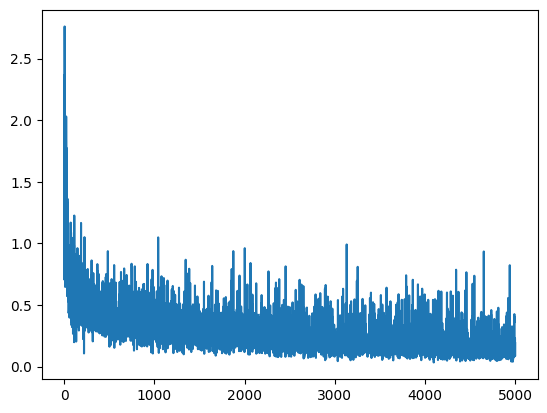

In [385]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(training_logs["loss"])),training_logs["loss"]) 

In [221]:
test_data_source = {}
test_data_target = {}
test_data_conditions = {}
adata_test = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test.h5ad")
source = adata_test[adata_test.obs["condition"]=="control"].obsm["X_pca"]
for cond in adata_test.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_test[adata_test.obs["condition"]==cond].obsm["X_pca"]
    condition_1 = adata_test[adata_test.obs["condition"]==cond].obsm["ecfp_drug_1"]
    condition_2 = adata_test[adata_test.obs["condition"]==cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(np.concatenate((condition_1[0,:][None,:],condition_2[0,:][None,:]), axis=0), axis=0)
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_conditions[cond] = conds

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [396]:
adata_test.obs

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,...,condition,pathway1,pathway2,split,control,cell_type,perturbation,cell_line,smiles_drug_1,smiles_drug_2
Cell,,,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_16_Lig_BC_2,sciPlex_theis,1.298964,3487,RT_16,Givinostat,SRT1720,B4,2154,2152,3485.0,...,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,Givinostat+SRT1720,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
A01_A02_RT_BC_16_Lig_BC_47,sciPlex_theis,0.638120,1713,RT_16,Givinostat,SRT1720,B4,1281,1281,1713.0,...,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,Givinostat+SRT1720,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
A01_A02_RT_BC_16_Lig_BC_55,sciPlex_theis,0.636630,1709,RT_16,Givinostat,SRT1720,B4,1269,1268,1708.0,...,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,Givinostat+SRT1720,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
A01_A02_RT_BC_16_Lig_BC_57,sciPlex_theis,3.330295,8940,RT_16,Givinostat,SRT1720,B4,4199,4198,8939.0,...,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,Givinostat+SRT1720,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
A01_A02_RT_BC_16_Lig_BC_6,sciPlex_theis,0.847474,2275,RT_16,Givinostat,SRT1720,B4,1584,1581,2272.0,...,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,Givinostat+SRT1720,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_A02_RT_BC_90_Lig_BC_36,sciPlex_theis,0.626572,1682,RT_90,Givinostat,Crizotinib,H6,1225,1224,1681.0,...,Givinostat+Crizotinib,HDAC inhibitor,EGFR inhibitor,test,0,A549,Givinostat+Crizotinib,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...
H12_A02_RT_BC_90_Lig_BC_5,sciPlex_theis,2.903764,7795,RT_90,Givinostat,Crizotinib,H6,3667,3663,7791.0,...,Givinostat+Crizotinib,HDAC inhibitor,EGFR inhibitor,test,0,A549,Givinostat+Crizotinib,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...
H12_A02_RT_BC_90_Lig_BC_96,sciPlex_theis,0.660844,1774,RT_90,Givinostat,Crizotinib,H6,1315,1313,1772.0,...,Givinostat+Crizotinib,HDAC inhibitor,EGFR inhibitor,test,0,A549,Givinostat+Crizotinib,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...


In [386]:
predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source, test_data_conditions)

In [391]:
from ot_pert.metrics import compute_metrics

ImportError: cannot import name 'compute_mean_metrics' from 'ot_pert.metrics' (/home/icb/dominik.klein/git_repos/ot_pert_reproducibility/src/ot_pert/metrics.py)

In [392]:
def compute_mean_metrics(metrics: Dict[str, Dict[str, float]]):
    metric_names = list(list(metrics.values())[0].keys())
    metric_dict = {met_name: [] for met_name in metric_names}
    for met in metric_names:
        stat = 0.0
        for vals in metrics.values():
            stat += vals[met]
        metric_dict[met] = stat/len(metrics)
    return metric_dict

In [388]:
metrics = jax.tree_util.tree_map(compute_metrics, test_data_source, test_data_target)

In [389]:
metrics

{'Alvespimycin+Pirarubicin': {'r_squared': -0.29950814120262126,
  'sinkhorn_div_01': Array(38.39657, dtype=float32),
  'sinkhorn_div_1': Array(37.111435, dtype=float32),
  'sinkhorn_div_10': Array(16.780907, dtype=float32),
  'e_distance': 1.9909521669271442,
  'mmd': Array(13.6084175, dtype=float32)},
 'Cediranib+PCI-34051': {'r_squared': 0.942392938278495,
  'sinkhorn_div_01': Array(23.916113, dtype=float32),
  'sinkhorn_div_1': Array(22.750998, dtype=float32),
  'sinkhorn_div_10': Array(3.743885, dtype=float32),
  'e_distance': 0.05635032675105389,
  'mmd': Array(0.6249008, dtype=float32)},
 'Dacinostat+Danusertib': {'r_squared': -3.000604544341078,
  'sinkhorn_div_01': Array(66.6324, dtype=float32),
  'sinkhorn_div_1': Array(65.09537, dtype=float32),
  'sinkhorn_div_10': Array(44.63218, dtype=float32),
  'e_distance': 5.531957485499465,
  'mmd': Array(41.653156, dtype=float32)},
 'Dacinostat+Dasatinib': {'r_squared': -2.8112897815015025,
  'sinkhorn_div_01': Array(68.649826, dtype

In [390]:
metrics_prediction =  jax.tree_util.tree_map(compute_metrics, predicted_target_test, test_data_target)

In [393]:
metrics_prediction

{'Alvespimycin+Pirarubicin': {'r_squared': 0.0461943447815959,
  'sinkhorn_div_01': Array(121.2691, dtype=float32),
  'sinkhorn_div_1': Array(120.236374, dtype=float32),
  'sinkhorn_div_10': Array(97.5441, dtype=float32),
  'e_distance': 5.2776427950864235,
  'mmd': Array(43.770584, dtype=float32)},
 'Cediranib+PCI-34051': {'r_squared': 0.2885621683159073,
  'sinkhorn_div_01': Array(112.379364, dtype=float32),
  'sinkhorn_div_1': Array(111.40526, dtype=float32),
  'sinkhorn_div_10': Array(91.01689, dtype=float32),
  'e_distance': 4.446493150252048,
  'mmd': Array(36.07248, dtype=float32)},
 'Dacinostat+Danusertib': {'r_squared': -0.772150888675639,
  'sinkhorn_div_01': Array(171.79695, dtype=float32),
  'sinkhorn_div_1': Array(170.68747, dtype=float32),
  'sinkhorn_div_10': Array(149.06532, dtype=float32),
  'e_distance': 9.162895278170492,
  'mmd': Array(92.9149, dtype=float32)},
 'Dacinostat+Dasatinib': {'r_squared': -0.29891798080113086,
  'sinkhorn_div_01': Array(143.79199, dtype=f

In [394]:
s_divs_valid

[{'Alvespimycin+Pirarubicin': Array(37.480278, dtype=float32),
  'Cediranib+PCI-34051': Array(22.808172, dtype=float32),
  'Dacinostat+Danusertib': Array(65.158676, dtype=float32),
  'Dacinostat+Dasatinib': Array(67.22008, dtype=float32),
  'Dacinostat+PCI-34051': Array(69.46284, dtype=float32),
  'Givinostat+Carmofur': Array(29.747753, dtype=float32),
  'Givinostat+Cediranib': Array(29.419748, dtype=float32),
  'Givinostat+Crizotinib': Array(29.203156, dtype=float32),
  'Givinostat+Curcumin': Array(28.262575, dtype=float32),
  'Givinostat+Dasatinib': Array(28.650684, dtype=float32),
  'Givinostat+SRT1720': Array(24.815353, dtype=float32),
  'Givinostat+SRT2104': Array(27.414984, dtype=float32),
  'Givinostat+Sorafenib': Array(40.768993, dtype=float32),
  'Givinostat+Tanespimycin': Array(33.172718, dtype=float32),
  'Panobinostat+Alvespimycin': Array(105.08519, dtype=float32),
  'Panobinostat+Crizotinib': Array(111.36747, dtype=float32),
  'Panobinostat+Curcumin': Array(91.41628, dtype

In [366]:
metric_names = list(list(metrics.values())[0].keys())


In [367]:
metric_names

['r_squared',
 'sinkhorn_div_01',
 'sinkhorn_div_1',
 'sinkhorn_div_10',
 'e_distance',
 'mmd']

In [368]:
metric_dict = {met_name: [] for met_name in metric_names}

In [369]:
metric_dict

{'r_squared': [],
 'sinkhorn_div_01': [],
 'sinkhorn_div_1': [],
 'sinkhorn_div_10': [],
 'e_distance': [],
 'mmd': []}

In [380]:
from typing import Dict
def compute_mean_metrics(metrics: Dict[str, Dict[str, float]]):
    metric_names = list(list(metrics.values())[0].keys())
    metric_dict = {met_name: [] for met_name in metric_names}
    for met in metric_names:
        stat = 0.0
        for vals in metrics.values():
            stat += vals[met]
        metric_dict[met] = stat/len(metrics)
    return metric_dict

In [381]:
compute_mean_metrics(metrics)

{'r_squared': -1.8694564915073884,
 'sinkhorn_div_01': Array(56.91391, dtype=float32),
 'sinkhorn_div_1': Array(55.60287, dtype=float32),
 'sinkhorn_div_10': Array(34.1385, dtype=float32),
 'e_distance': 3.6756179333329366,
 'mmd': Array(29.905327, dtype=float32)}

In [374]:
metric_dict

{'r_squared': -1.8694564915073884,
 'sinkhorn_div_01': Array(56.91391, dtype=float32),
 'sinkhorn_div_1': Array(55.60287, dtype=float32),
 'sinkhorn_div_10': Array(34.1385, dtype=float32),
 'e_distance': 3.6756179333329366,
 'mmd': Array(29.905327, dtype=float32)}

In [364]:
average = get_average_of_values(metrics, 'value')

TypeError: argument of type 'numpy.float64' is not iterable